# Introduction & Setup :

In [31]:
!pip install datasets kagglehub -q

import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from datasets import load_dataset

import kagglehub
from kagglehub import KaggleDatasetAdapter
from torch.utils.data import TensorDataset, DataLoader

from datasets import load_dataset

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"The model will work on this device.: {device}")

The model will work on this device.: cuda


# Functions to be used for data manipulation :

In [33]:
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text.lower().split()

In [34]:
def build_vocab_optimized(sentences, max_vocab_size=20000):
  word_counts = Counter()

  for item in sentences:

        if isinstance(item, list):
            tokens = item

        elif isinstance(item, dict) and 'text' in item:
            tokens = clean_text(item['text'])

        elif isinstance(item, str):
            tokens = clean_text(item)

        else:
            continue

        word_counts.update(tokens)

  most_common_words = word_counts.most_common(max_vocab_size)
  vocab = {"<PAD>": 0, "<UNK>": 1}

  for word, count in most_common_words:
        vocab[word] = len(vocab)

  print(f"✅ Vocab Hazır! Boyut: {len(vocab)}")
  return vocab

In [35]:
def encode_and_pad(input_data, vocab, max_len=250):
  if isinstance(input_data, str):
        input_data = [input_data]

  encoded_batch = []
  pad_id = vocab.get('<PAD>', 0)
  unk_id = vocab.get('<UNK>', 1)

  for item in input_data:
        if isinstance(item, list):
            tokens = item
        else:
            tokens = clean_text(item)

        encoded = [vocab.get(word, unk_id) for word in tokens]

        if len(encoded) < max_len:
            padding = [pad_id] * (max_len - len(encoded))
            encoded = padding + encoded
        else:
            encoded = encoded[:max_len]

        encoded_batch.append(encoded)

  if len(encoded_batch) == 1 and len(input_data) == 1:
         return encoded_batch[0]

  return encoded_batch

In [36]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

In [37]:
def predict_sentiment(text, model, vocab, device):
    model.eval()

    encoded = encode_and_pad(text, vocab)

    tensor_text = torch.tensor(encoded).unsqueeze(0).to(device)

    h = None
    with torch.no_grad():
        prediction, _ = model(tensor_text, h)

    score = prediction.item()
    status = "Positive" if score > 0.5 else "Negative"

    print(f"Input: '{text}'")
    print(f"Score: {score:.4f} -> Result: {status}")
    print("-" * 30)


In [38]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        hidden_last_layer = torch.cat((hidden[0][-2,:,:], hidden[0][-1,:,:]), dim=1)

        out = self.dropout(hidden_last_layer)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        number_of_layers = self.n_layers * 2

        hidden = (weight.new(number_of_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(number_of_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [39]:
def plot_history(train_loss, val_loss):
    steps = range(100, len(train_loss) * 100 + 1, 100)

    plt.figure(figsize=(10, 6))

    plt.plot(steps, train_loss, 'b-', label='Training Loss')
    plt.plot(steps, val_loss, 'r-', label='Validation Loss')

    plt.title('Training & Validation Loss (Step-by-Step)')
    plt.xlabel('Steps (Adımlar)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Phase 1: The Kaggle Dataset :

## Data Loading Process :

In [40]:
print("Phase 1: Downloading Kaggle Dataset...")

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print(f"Data Set Path: {path}")

csv_path = os.path.join(path, "IMDB Dataset.csv")

try:
    df_kaggle = pd.read_csv(csv_path)
    print("\n--- Kaggle Dataset (First 5 Rows) ---")
    print(df_kaggle.head())
    print(f"Dataset Shape: {df_kaggle.shape}")

except FileNotFoundError:
    print("Error: CSV file not found in the specified path.")

Phase 1: Downloading Kaggle Dataset...
Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Data Set Path: /kaggle/input/imdb-dataset-of-50k-movie-reviews

--- Kaggle Dataset (First 5 Rows) ---
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Dataset Shape: (50000, 2)


In [41]:
print("Data is being cleaning...")
cleaned_reviews = [clean_text(review) for review in df_kaggle['review']]
print("Data has cleaned")

Data is being cleaning...
Data has cleaned


In [42]:
labels = [1 if sentiment == "positive" else 0 for sentiment in df_kaggle['sentiment']]
labels = np.array(labels)

In [43]:
vocab_kaggle = build_vocab_optimized(cleaned_reviews, max_vocab_size=20000)

✅ Vocab Hazır! Boyut: 20002


In [44]:
print(f"The ID of the word 'film': {vocab_kaggle.get('film')}")
print(f"The ID of a non-existent word (If it returns None, we will set it to 1 in the encode part): {vocab_kaggle.get('zartzurt')}")

The ID of the word 'film': 20
The ID of a non-existent word (If it returns None, we will set it to 1 in the encode part): None


In [45]:
encoded_list = encode_and_pad(cleaned_reviews, vocab_kaggle, max_len=250)
input_tensor_kg = torch.tensor(encoded_list)
target_tensor_kg = torch.tensor(labels).float()

if isinstance(labels, torch.Tensor):
    target_tensor = labels.clone().detach().float()
else:
    target_tensor = torch.tensor(labels).float()

if len(input_tensor_kg) != len(target_tensor_kg):
    print(f"⚠️ UYARI: Boyut uyuşmazlığı tespit edildi! (Input: {len(input_tensor_kg)}, Target: {len(target_tensor_kg)})")
    print("⚠️ İşleme devam edebilmek için Target tensörü, Input boyutuna göre kesiliyor/hizalanıyor.")


    if len(input_tensor_kg) < len(target_tensor_kg):
        target_tensor_kg = target_tensor[:len(input_tensor_kg)]

    else:
        raise ValueError("Target (Labels) verisi Input verisinden daha AZ! Lütfen 'labels' değişkenini kontrol et.")

split_idx_1 = int(len(input_tensor_kg) * 0.8)
split_idx_2 = int(len(input_tensor_kg) * 0.9)

train_x, val_x, test_x = input_tensor_kg[:split_idx_1], input_tensor_kg[split_idx_1:split_idx_2], input_tensor_kg[split_idx_2:]
train_y, val_y, test_y = target_tensor_kg[:split_idx_1], target_tensor_kg[split_idx_1:split_idx_2], target_tensor_kg[split_idx_2:]

print(f"Train Set: {train_x.shape}")
print(f"Validation Set: {val_x.shape}")
print(f"Test Set: {test_x.shape}")

batch_size_kaggle = 64

train_data = TensorDataset(train_x, train_y)
train_loader_kaggle = DataLoader(train_data, shuffle=True, batch_size=batch_size_kaggle)

val_data = TensorDataset(val_x, val_y)
val_loader_kaggle = DataLoader(val_data, shuffle=True, batch_size=batch_size_kaggle)

test_data = TensorDataset(test_x, test_y)
test_loader_kaggle = DataLoader(test_data, shuffle=True, batch_size=batch_size_kaggle)

Train Set: torch.Size([40000, 250])
Validation Set: torch.Size([5000, 250])
Test Set: torch.Size([5000, 250])


In [46]:
vocab_size_k = len(vocab_kaggle) + 1
embedding_dim_k = 400
hidden_dim_k = 256
output_dim_k = 1
n_layers_k = 2
drop_prob = 0.5
lr_k = 0.001
epochs_k = 5
print_every_k = 100
clip_k = 5
counter = 0
batch_size_kaggle = 64

model_kaggle = SentimentLSTM(vocab_size_k, embedding_dim_k, hidden_dim_k, output_dim_k, n_layers_k,drop_prob)
model_kaggle.to(device)
print(model_kaggle)

SentimentLSTM(
  (embedding): Embedding(20003, 400, padding_idx=0)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [47]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_kaggle.parameters(), lr=lr_k)

model_kaggle.train()

train_losses_history_kaggle = []
val_losses_history_kaggle = []


for epoch in range(epochs_k):
  h = model_kaggle.init_hidden(batch_size_kaggle)
  model_kaggle.train()
  train_losses = []
  counter = 0

  for inputs, labels in train_loader_kaggle:
        counter += 1
        if inputs.size(0) != batch_size_kaggle: continue
        inputs, labels = inputs.to(device), labels.to(device).float()

        h = tuple([each.data for each in h])

        model_kaggle.zero_grad()
        output, h = model_kaggle(inputs, h)

        loss = criterion(output.squeeze(), labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model_kaggle.parameters(), clip_k)
        optimizer.step()
        train_losses.append(loss.item())

        if counter % print_every_k == 0:
            val_h = model_kaggle.init_hidden(batch_size_kaggle)
            val_losses = []
            val_accs = []
            model_kaggle.eval()

            with torch.no_grad():
                for inputs, labels in val_loader_kaggle:
                    if inputs.size(0) != batch_size_kaggle: continue

                    val_h = tuple([each.data for each in val_h])
                    inputs, labels = inputs.to(device), labels.to(device).float()

                    output, val_h = model_kaggle(inputs, val_h)

                    val_loss = criterion(output.squeeze(), labels)
                    val_losses.append(val_loss.item())

                    preds = torch.round(output.squeeze())
                    acc = (preds == labels).float().mean()
                    val_accs.append(acc.item())

            model_kaggle.train()

            this_val_loss = np.mean(val_losses)
            this_val_acc = np.mean(val_accs)

            train_losses_history_kaggle.append(loss.item())
            val_losses_history_kaggle.append(this_val_loss)

            print(f"Epoch: {epoch+1}/{epochs_k}...",
                  f"Step: {counter}...",
                  f"Loss: {loss.item():.6f}...",
                  f"Val Loss: {this_val_loss:.6f}",
                  f"Val Acc: %{this_val_acc*100:.2f}")


Epoch: 1/5... Step: 100... Loss: 0.659896... Val Loss: 0.634173 Val Acc: %63.24
Epoch: 1/5... Step: 200... Loss: 0.577048... Val Loss: 0.578636 Val Acc: %70.27
Epoch: 1/5... Step: 300... Loss: 0.539347... Val Loss: 0.522802 Val Acc: %74.48
Epoch: 1/5... Step: 400... Loss: 0.475225... Val Loss: 0.480848 Val Acc: %77.46
Epoch: 1/5... Step: 500... Loss: 0.585918... Val Loss: 0.611028 Val Acc: %68.39
Epoch: 1/5... Step: 600... Loss: 0.515743... Val Loss: 0.647302 Val Acc: %60.38
Epoch: 2/5... Step: 100... Loss: 0.406719... Val Loss: 0.456540 Val Acc: %79.99
Epoch: 2/5... Step: 200... Loss: 0.488435... Val Loss: 0.457844 Val Acc: %81.83
Epoch: 2/5... Step: 300... Loss: 0.275598... Val Loss: 0.370458 Val Acc: %84.92
Epoch: 2/5... Step: 400... Loss: 0.428056... Val Loss: 0.347203 Val Acc: %84.88
Epoch: 2/5... Step: 500... Loss: 0.249607... Val Loss: 0.322291 Val Acc: %86.16
Epoch: 2/5... Step: 600... Loss: 0.346385... Val Loss: 0.336493 Val Acc: %85.48
Epoch: 3/5... Step: 100... Loss: 0.16914

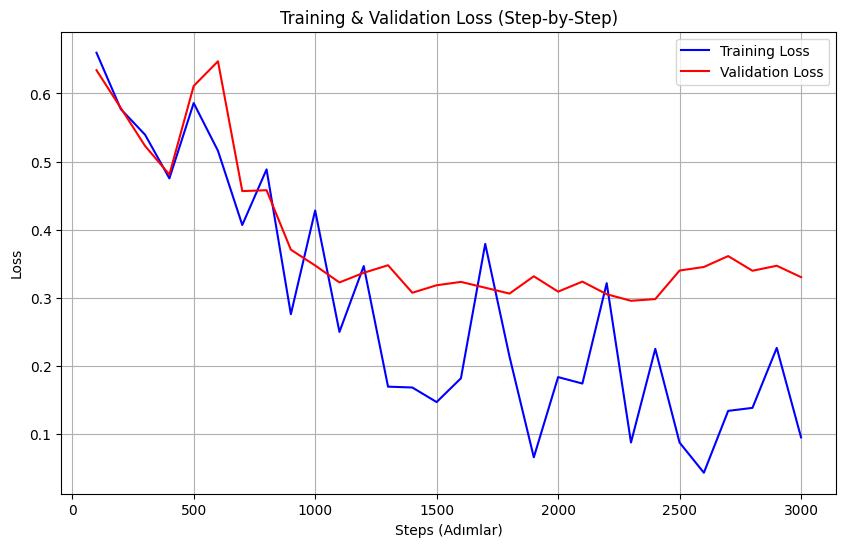

In [48]:
plot_history(train_losses_history_kaggle, val_losses_history_kaggle)

- As can be seen from the model outputs and graph above, our model undergoes overfitting after a certain point (see Step 2200 - Epoch: 4). The graph clearly shows that the Training_Loss and Validation_Loss values ​​begin to diverge between Steps 2200 and 2400. Our model achieved its best val_Loss at Step 2200, reaching a val_loss of 0.312; our val_acc value was 87.58%.

- These scores, obtained using only LSTM with a synthetic dataset from Kaggle and without any BERT or Transformer architecture, are acceptable results. Our LSTM model understands words, can decipher sentence structures and irony, and its generalization ability is at the desired level. I want to test our model against the best-performing point we have. Let's see the result together.

In [49]:
model_final = SentimentLSTM(vocab_size_k, embedding_dim_k, hidden_dim_k, output_dim_k, n_layers_k, drop_prob)
model_final.to(device)
optimizer = torch.optim.Adam(model_final.parameters(), lr=lr_k)

for epoch in range(3):
    h = model_final.init_hidden(batch_size_kaggle)
    model_final.train()

    for inputs, labels in train_loader_kaggle:
        if inputs.size(0) != batch_size_kaggle: continue
        inputs, labels = inputs.to(device), labels.to(device).float()
        h = tuple([each.data for each in h])

        model_final.zero_grad()
        output, h = model_final(inputs, h)
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model_final.parameters(), clip_k)
        optimizer.step()


torch.save(model_final.state_dict(), 'sentiment_bilstm_final.pt')

In [50]:
challenge_sentences = [
    "I hated this film, it was a total waste of time.",
    "This movie was absolutely amazing and the acting was great.",
    "I really wanted to like this movie but I couldn't.",
    "The cinematography was good but the plot was boring.",
    "It was not bad at all.",
    "Best movie ever? I don't think so."
]


for sent in challenge_sentences:
    predict_sentiment(sent, model_final, vocab_kaggle, device)


Input: 'I hated this film, it was a total waste of time.'
Score: 0.0086 -> Result: Negative
------------------------------
Input: 'This movie was absolutely amazing and the acting was great.'
Score: 0.9921 -> Result: Positive
------------------------------
Input: 'I really wanted to like this movie but I couldn't.'
Score: 0.1279 -> Result: Negative
------------------------------
Input: 'The cinematography was good but the plot was boring.'
Score: 0.0479 -> Result: Negative
------------------------------
Input: 'It was not bad at all.'
Score: 0.4288 -> Result: Negative
------------------------------
Input: 'Best movie ever? I don't think so.'
Score: 0.9761 -> Result: Positive
------------------------------


**The model perfectly solved the "routine" sentences (I hated it, I loved it, but...). Even correctly identifying a complex structure like "I really wanted to like..." proves that LSTM works.**

- Why Did It Go Wrong? (The Failure Analysis)**

    * 1."Best movie ever? I don't think so." -> (Why did it say Positive?)

      - **Criminal 1:** Tokenizer. The re.findall(r"\w+", text) function we used removes punctuation marks.

      - What the model sees is: best movie ever i don't think so

      - Because the question mark (?) is gone, the sarcastic/questioning tone is lost.

      - **Criminal 2:** Word Weights. The words "best," "movie," and "ever" are so positive in the Embedding space that the faint "don't think so" at the end wasn't enough to erase this massive positive wave (triggering LSTM's Forget Gate).

    * 2."It was not bad at all." -> (Why did it say negative?)

      - **The criminal:** The dominance of the word "bad."

      - In the training set (IMDB), the word "bad" appears in negative reviews 95% of the time. The structure "not bad" is less common.

      - When LSTM reads sequentially, it sees "not," then when it sees "bad," it thinks, "Okay, this is definitely something bad." The phrase "at all" seems neutral to it and it can't nullify the effect of "bad."

# Phase 2 : HugginFace IMDB Dataset :

In [51]:
try:
  dataset = load_dataset("imdb")
  print("Success! Dataset loaded.")
  print(f"Training Data Size: {len(dataset['train'])} comments")
  print(f"Test Data Size: {len(dataset['test'])} comments")

  print("\n--- Example Data (Raw) ---")
  print(dataset['train'][0])

except Exception as e:
    print(f"An Error Occured: {e}")

Success! Dataset loaded.
Training Data Size: 25000 comments
Test Data Size: 25000 comments

--- Example Data (Raw) ---
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURI

In [52]:
word_counts = Counter()

for example in dataset['train']:
    tokens = clean_text(example['text'])
    word_counts.update(tokens)

vocab_hf = {"<PAD>": 0, "<UNK>": 1}
sorted_words = word_counts.most_common(20000)

for word, count in sorted_words:
    vocab_hf[word] = len(vocab_hf)

In [53]:
train_x_list = [encode_and_pad(text, vocab_hf) for text in dataset['train']['text']]
train_x = torch.tensor(train_x_list)
train_y = torch.tensor([label for label in dataset['train']['label']]).float()

test_x_list = [encode_and_pad(text, vocab_hf) for text in dataset['test']['text']]
test_x = torch.tensor(test_x_list)
test_y = torch.tensor([label for label in dataset['test']['label']]).float()


print(f"✅ Train Shape: {train_x.shape}")
print(f"✅ Test Shape: {test_x.shape}")


batch_size = 64
train_loader = DataLoader(TensorDataset(train_x, train_y), shuffle=True, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(test_x, test_y), shuffle=False, batch_size=batch_size)

✅ Train Shape: torch.Size([25000, 250])
✅ Test Shape: torch.Size([25000, 250])


In [54]:
vocab_size_hf = len(vocab_hf) + 1
embedding_dim_hf = 128
hidden_dim_hf = 256
output_dim_hf = 1
n_layers_hf = 2
batch_size_hf = 64
print_every_hf = 100
epochs_hf = 5
clip_hf = 5
drop_prob = 0.5
lr_hf = 0.001

model_hf = SentimentLSTM(vocab_size_hf, embedding_dim_hf, hidden_dim_hf, output_dim_hf, n_layers_hf,drop_prob)
model_hf.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_hf.parameters(), lr=lr_hf)

model_hf.train()
counter = 0

train_losses_history_hf = []
val_losses_history_hf = []


for epoch in range(epochs_hf):
    h = model_hf.init_hidden(batch_size_hf)
    model_hf.train()
    train_losses = []
    counter = 0

    for inputs, labels in train_loader:
        counter += 1
        if inputs.size(0) != batch_size_hf: continue

        inputs, labels = inputs.to(device), labels.to(device).float()
        h = tuple([each.data for each in h])

        model_hf.zero_grad()
        output, h = model_hf(inputs, h)
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model_hf.parameters(), clip_hf)
        optimizer.step()
        train_losses.append(loss.item())

        if counter % print_every_hf == 0:
            val_h = model_hf.init_hidden(batch_size_hf)
            val_losses = []
            val_accs = []
            model_hf.eval()

            with torch.no_grad():
                for inputs, labels in test_loader:
                    if inputs.size(0) != batch_size_hf: continue
                    val_h = tuple([each.data for each in val_h])
                    inputs, labels = inputs.to(device), labels.to(device).float()

                    output, val_h = model_hf(inputs, val_h)
                    val_loss = criterion(output.squeeze(), labels)
                    val_losses.append(val_loss.item())

                    preds = torch.round(output.squeeze())
                    acc = (preds == labels).float().mean()
                    val_accs.append(acc.item())

            model_hf.train()

            this_val_loss = np.mean(val_losses)
            this_val_acc = np.mean(val_accs)

            train_losses_history_hf.append(loss.item())
            val_losses_history_hf.append(this_val_loss)

            print(f"Epoch: {epoch+1}/{epochs_hf} | Step: {counter} | "
                  f"Loss: {loss.item():.4f} | Val Loss: {this_val_loss:.4f} | "
                  f"Val Acc: %{this_val_acc*100:.2f}")

Epoch: 1/5 | Step: 100 | Loss: 0.6230 | Val Loss: 0.6627 | Val Acc: %59.83
Epoch: 1/5 | Step: 200 | Loss: 0.5789 | Val Loss: 0.6065 | Val Acc: %66.51
Epoch: 1/5 | Step: 300 | Loss: 0.5753 | Val Loss: 0.6090 | Val Acc: %66.50
Epoch: 2/5 | Step: 100 | Loss: 0.6601 | Val Loss: 0.5735 | Val Acc: %70.34
Epoch: 2/5 | Step: 200 | Loss: 0.7844 | Val Loss: 0.7501 | Val Acc: %49.92
Epoch: 2/5 | Step: 300 | Loss: 0.7086 | Val Loss: 0.6899 | Val Acc: %51.43
Epoch: 3/5 | Step: 100 | Loss: 0.5263 | Val Loss: 0.4976 | Val Acc: %77.27
Epoch: 3/5 | Step: 200 | Loss: 0.4329 | Val Loss: 0.5112 | Val Acc: %76.96
Epoch: 3/5 | Step: 300 | Loss: 0.3623 | Val Loss: 0.4076 | Val Acc: %82.78
Epoch: 4/5 | Step: 100 | Loss: 0.3937 | Val Loss: 0.3316 | Val Acc: %86.51
Epoch: 4/5 | Step: 200 | Loss: 0.3141 | Val Loss: 0.3733 | Val Acc: %84.86
Epoch: 4/5 | Step: 300 | Loss: 0.2716 | Val Loss: 0.3871 | Val Acc: %83.43
Epoch: 5/5 | Step: 100 | Loss: 0.5808 | Val Loss: 0.6081 | Val Acc: %67.17
Epoch: 5/5 | Step: 200 | 

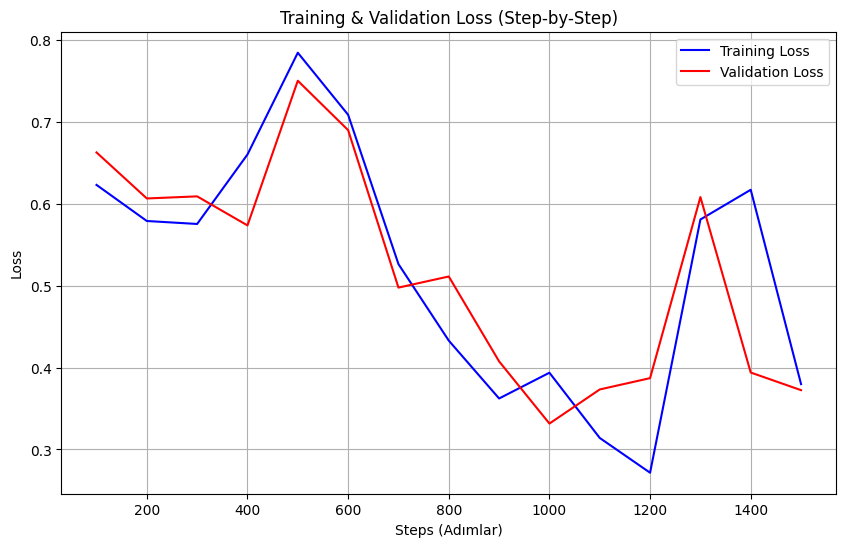

In [55]:
plot_history(train_losses_history_hf, val_losses_history_hf)

In [56]:
model_final_hf = SentimentLSTM(vocab_size_hf, embedding_dim_hf, hidden_dim_hf, output_dim_hf, n_layers_hf, drop_prob)
model_final_hf.to(device)

optimizer = torch.optim.Adam(model_final_hf.parameters(), lr=lr_hf)

for epoch in range(5):
    h = model_final_hf.init_hidden(batch_size_hf)
    model_final_hf.train()

    for inputs, labels in train_loader:

        if inputs.size(0) != batch_size_hf: continue

        inputs, labels = inputs.to(device), labels.to(device).float()

        h = tuple([each.data for each in h])

        model_final_hf.zero_grad()
        output, h = model_final_hf(inputs, h)

        loss = criterion(output.squeeze(), labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model_final_hf.parameters(), clip_hf)
        optimizer.step()

    print(f"Epoch {epoch+1}/5 Has Completed !")


torch.save(model_final_hf.state_dict(), 'sentiment_bilstm_hf_final.pt')

Epoch 1/5 Has Completed !
Epoch 2/5 Has Completed !
Epoch 3/5 Has Completed !
Epoch 4/5 Has Completed !
Epoch 5/5 Has Completed !


In [57]:
challenge_sentences = [
    "I hated this film, it was a total waste of time.",
    "This movie was absolutely amazing and the acting was great.",
    "I really wanted to like this movie but I couldn't.",
    "The cinematography was good but the plot was boring.",
    "It was not bad at all.",
    "Best movie ever? I don't think so."
]

for sent in challenge_sentences:

    predict_sentiment(sent, model_final_hf, vocab_hf, device)

Input: 'I hated this film, it was a total waste of time.'
Score: 0.0052 -> Result: Negative
------------------------------
Input: 'This movie was absolutely amazing and the acting was great.'
Score: 0.9861 -> Result: Positive
------------------------------
Input: 'I really wanted to like this movie but I couldn't.'
Score: 0.5373 -> Result: Positive
------------------------------
Input: 'The cinematography was good but the plot was boring.'
Score: 0.1573 -> Result: Negative
------------------------------
Input: 'It was not bad at all.'
Score: 0.4217 -> Result: Negative
------------------------------
Input: 'Best movie ever? I don't think so.'
Score: 0.9539 -> Result: Positive
------------------------------
